<a href="https://colab.research.google.com/github/Muhammad-BILAL-5/Reflection-Agents/blob/main/LATS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Langchain Agent Tree Search (LATS)

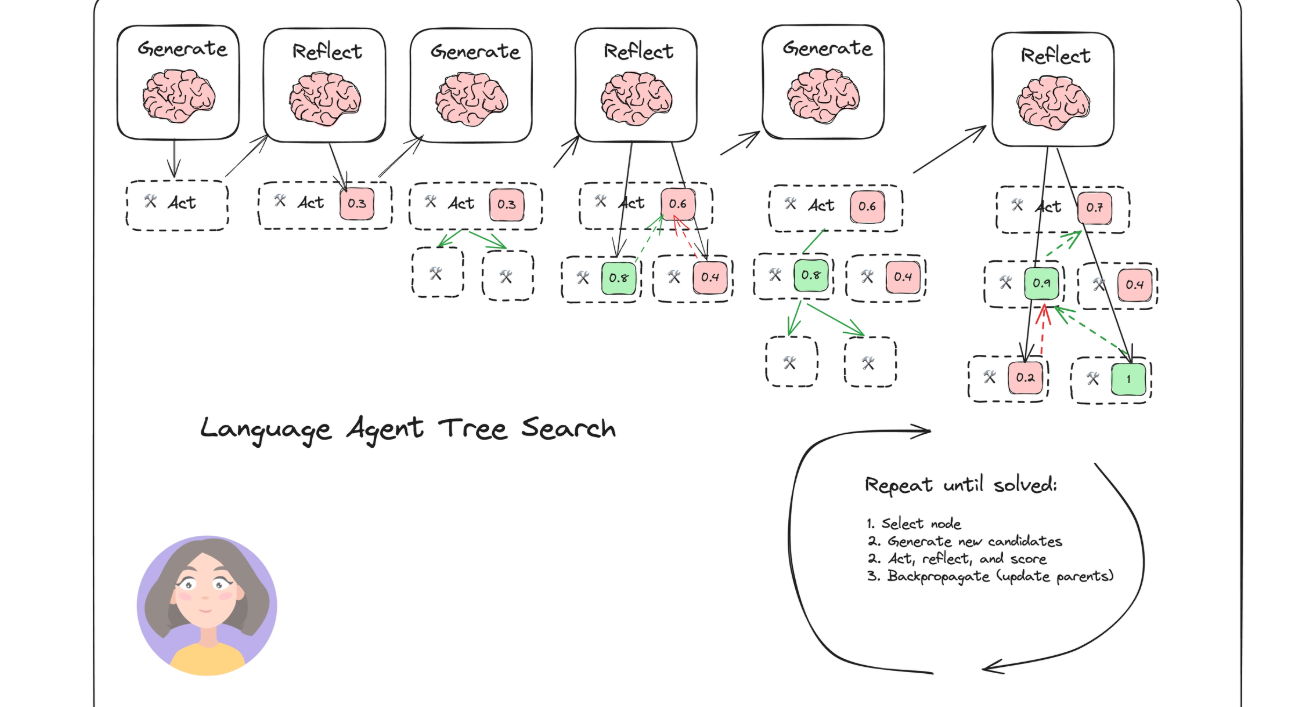

In [ ]:
!pip install --quiet --upgrade langchain langchain-google-genai langgraph

In [ ]:
from google.colab import userdata
import os

os.environ["LANGCHAIN_API_KEY"] = userdata.get("langchai_api_key")
os.environ["GOOGLE_API_KEY"] = userdata.get("Gemini_Api_Key")
os.environ["TAVILY_API_KEY"] = userdata.get("tavily_api_key")

In [ ]:
import math
from collections import deque
from typing import Optional

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage

from pydantic import BaseModel, Field


class Reflection(BaseModel):
    reflections: str = Field(
        description="The critique and reflections on the sufficiency, superfluency,"
        " and general quality of the response"
    )
    score: int = Field(
        description="Score from 0-10 on the quality of the candidate response.",
        gte=0,
        lte=10,
    )
    found_solution: bool = Field(
        description="Whether the response has fully solved the question or task."
    )

    def as_message(self):
        return HumanMessage(
            content=f"Reasoning: {self.reflections}\nScore: {self.score}"
        )

    @property
    def normalized_score(self) -> float:
        return self.score / 10.0

class Node:
    def __init__(
        self,
        messages: list[BaseMessage],
        reflection: Reflection,
        parent: Optional["Node"] = None,
    ):
        self.messages = messages
        self.parent = parent
        self.children = []
        self.value = 0
        self.visits = 0
        self.reflection = reflection
        self.depth = parent.depth + 1 if parent is not None else 1
        self._is_solved = reflection.found_solution if reflection else False
        if self._is_solved:
            self._mark_tree_as_solved()
        self.backpropagate(reflection.normalized_score)

    def __repr__(self) -> str:
        return (
            f"<Node value={self.value}, visits={self.visits},"
            f" solution={self.messages} reflection={self.reflection}/>"
        )

    @property
    def is_solved(self):
        """If any solutions exist, we can end the search."""
        return self._is_solved
    @property
    def is_terminal(self):
        return not self.children

    @property
    def best_child_score(self):
        """Return the child with the highest value."""
        if not self.children:
            return None
        return max(self.children, key=lambda child: int(child.is_solved) * child.value)

    @property
    def height(self) -> int:
        """Check for how far we've rolled out the tree."""
        if self.children:
            return 1 + max([child.height for child in self.children])
        return 1

    def upper_confidence_bound(self, exploration_weight=1.0):
        """Return the UCT score. This helps balance exploration vs. exploitation of a branch."""
        if self.parent is None:
            raise ValueError("Cannot obtain UCT from root node")
        if self.visits == 0:
            return self.value
        # Encourages exploitation of high-value trajectories
        average_reward = self.value / self.visits
        # Encourages exploration of less-visited trajectories
        exploration_term = math.sqrt(math.log(self.parent.visits) / self.visits)
        return average_reward + exploration_weight * exploration_term
   def backpropagate(self, reward: float):
        """Update the score of this node and its parents."""
        node = self
        while node:
            node.visits += 1
            node.value = (node.value * (node.visits - 1) + reward) / node.visits
            node = node.parent

    def get_messages(self, include_reflections: bool = True):
        if include_reflections:
            return self.messages + [self.reflection.as_message()]
        return self.messages

    def get_trajectory(self, include_reflections: bool = True) -> list[BaseMessage]:
        """Get messages representing this search branch."""
        messages = []
        node = self
        while node:
            messages.extend(
                node.get_messages(include_reflections=include_reflections)[::-1]
            )
            node = node.parent
        # Reverse the final back-tracked trajectory to return in the correct order
        return messages[::-1]  # root solution, reflection, child 1, ...

    def _get_all_children(self):
        all_nodes = []
        nodes = deque()
        nodes.append(self)
        while nodes:
            node = nodes.popleft()
            all_nodes.extend(node.children)
            for n in node.children:
                nodes.append(n)
        return all_nodes

    def get_best_solution(self):
        """Return the best solution from within the current sub-tree."""
        all_nodes = [self] + self._get_all_children()
        best_node = max(
            all_nodes,
            # We filter out all non-terminal, non-solution trajectories
            key=lambda node: int(node.is_terminal and node.is_solved) * node.value,
        )
        return best_node

    def _mark_tree_as_solved(self):
        parent = self.parent
        while parent:
            parent._is_solved = True
            parent = parent.parent


In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langgraph.prebuilt import ToolNode
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(temperature=0,model="gemini-1.5-flash-8b")

search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)
tools = [tavily_tool]
tool_node = ToolNode(tools=tools)

In [ ]:
from langchain_core.output_parsers.openai_tools import (
    JsonOutputToolsParser,
    PydanticToolsParser,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import chain as as_runnable

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Reflect and grade the assistant response to the user question below.",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="candidate"),
    ]
)

reflection_llm_chain = (
    prompt
    | llm.bind_tools(tools=[Reflection], tool_choice="Reflection").with_config(
        run_name="Reflection"
    )
    | PydanticToolsParser(tools=[Reflection])
)

In [ ]:
# Define the node we will add to the graph
def generate_initial_response(state: TreeState) -> dict:
    """Generate the initial candidate response."""
    res = initial_answer_chain.invoke({"input": state["input"]})
    parsed = parser.invoke(res)
    tool_responses = [
        tool_node.invoke(
            {
                "messages": [
                    AIMessage(
                        content="",
                        tool_calls=[
                            {"name": r["type"], "args": r["args"], "id": r["id"]}
                        ],
                    )
                ]
            }
        )
        for r in parsed
    ]
    output_messages = [res] + [tr["messages"][0] for tr in tool_responses]
    reflection = reflection_chain.invoke(
        {"input": state["input"], "candidate": output_messages}
    )
    root = Node(output_messages, reflection=reflection)
    return {
        **state,
        "root": root,
    }

# This generates N candidate values
# for a single input to sample actions from the environment


def generate_candidates(messages: ChatPromptValue, config: RunnableConfig):
    n = config["configurable"].get("N", 5)
    bound_kwargs = llm.bind_tools(tools=tools).kwargs
    chat_result = llm.generate(
        [messages.to_messages()],
        n=n,
        callbacks=config["callbacks"],
        run_name="GenerateCandidates",
        **bound_kwargs,
    )
    return [gen.message for gen in chat_result.generations[0]]


expansion_chain = prompt_template | generate_candidates
res = expansion_chain.invoke({"input": "Write a research report on lithium pollution."})
res

In [ ]:
from collections import defaultdict


def select(root: Node) -> dict:
    """Starting from the root node a child node is selected at each tree level until a leaf node is reached."""

    if not root.children:
        return root

    node = root
    while node.children:
        max_child = max(node.children, key=lambda child: child.upper_confidence_bound())
        node = max_child

    return node

In [ ]:
def expand(state: TreeState, config: RunnableConfig) -> dict:
    """Starting from the "best" node in the tree, generate N candidates for the next step."""
    root = state["root"]
    best_candidate: Node = select(root)
    messages = best_candidate.get_trajectory()
    # Generate N candidates from the single child candidate
    new_candidates = expansion_chain.invoke(
        {"input": state["input"], "messages": messages}, config
    )
    parsed = parser.batch(new_candidates)
    flattened = [
        (i, tool_call)
        for i, tool_calls in enumerate(parsed)
        for tool_call in tool_calls
    ]
    tool_responses = [
        (
            i,
            tool_node.invoke(
                {
                    "messages": [
                        AIMessage(
                            content="",
                            tool_calls=[
                                {
                                    "name": tool_call["type"],
                                    "args": tool_call["args"],
                                    "id": tool_call["id"],
                                }
                            ],
                        )
                    ]
                }
            ),
        )
        for i, tool_call in flattened
    ]
    collected_responses = defaultdict(list)
    for i, resp in tool_responses:
        collected_responses[i].append(resp["messages"][0])
    output_messages = []
    for i, candidate in enumerate(new_candidates):
        output_messages.append([candidate] + collected_responses[i])

    # Reflect on each candidate
    # For tasks with external validation, you'd add that here.
    reflections = reflection_chain.batch(
        [{"input": state["input"], "candidate": msges} for msges in output_messages],
        config,
    )
    # Grow tree
    child_nodes = [
        Node(cand, parent=best_candidate, reflection=reflection)
        for cand, reflection in zip(output_messages, reflections)
    ]
    best_candidate.children.extend(child_nodes)
    # We have already extended the tree directly, so we just return the state
    return state

In [ ]:
from typing import Literal

from langgraph.graph import END, StateGraph, START


def should_loop(state: TreeState):
    """Determine whether to continue the tree search."""
    root = state["root"]
    if root.is_solved:
        return END
    if root.height > 5:
        return END
    return "expand"


builder = StateGraph(TreeState)
builder.add_node("start", generate_initial_response)
builder.add_node("expand", expand)
builder.add_edge(START, "start")


builder.add_conditional_edges(
    "start",
    # Either expand/rollout or finish
    should_loop,
    ["expand", END],
)
builder.add_conditional_edges(
    "expand",
    # Either continue to rollout or finish
    should_loop,
    ["expand", END],
)

graph = builder.compile()

In [ ]:

from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())